# Order feats, std target by meter type

# Imports

In [1]:
%matplotlib inline

import src.utils as udf

import gc
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Lasso

import lightgbm as lgb
import xgboost as xgb

# Data

In [2]:
path = '../data/'

In [3]:
train = pd.read_pickle(f'{path}from_mod/train.pkl')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 18 columns):
building_id           uint16
meter                 uint8
meter_reading         float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(7), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 1.1+ GB


In [4]:
train = udf.reduce_mem_usage(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 18 columns):
building_id           uint16
meter                 uint8
meter_reading         float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(7), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 1.1+ GB


In [5]:
test = pd.read_pickle(f'{path}from_sub/test.pkl')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 17 columns):
building_id           uint16
meter                 uint8
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             int64
hour                  int64
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            int64
country               object
is_holiday            int64
dtypes: float32(6), int64(4), object(2), uint16(2), uint32(1), uint8(2)
memory usage: 3.5+ GB


In [6]:
test = udf.reduce_mem_usage(test)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 17 columns):
building_id           uint16
meter                 uint8
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(6), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 2.4+ GB


In [7]:
submission = pd.read_csv(f'{path}raw/test/sample_submission.csv')
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
row_id           int64
meter_reading    int64
dtypes: int64(2)
memory usage: 636.3 MB


In [8]:
submission = udf.reduce_mem_usage(submission)
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
row_id           uint32
meter_reading    uint8
dtypes: uint32(1), uint8(1)
memory usage: 198.8 MB


In [9]:
mb = pd.read_pickle(f'{path}from_sub/mb.pkl')
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 9 columns):
row_id          uint32
building_id     uint16
meter           uint8
timestamp       datetime64[ns]
site_id         uint8
primary_use     object
square_feet     uint32
year_built      uint16
missing_year    uint8
dtypes: datetime64[ns](1), object(1), uint16(2), uint32(2), uint8(3)
memory usage: 1.5+ GB


In [10]:
mb = udf.reduce_mem_usage(mb)
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 9 columns):
row_id          uint32
building_id     uint16
meter           uint8
timestamp       datetime64[ns]
site_id         uint8
primary_use     object
square_feet     uint32
year_built      uint16
missing_year    uint8
dtypes: datetime64[ns](1), object(1), uint16(2), uint32(2), uint8(3)
memory usage: 1.5+ GB


In [11]:
del path
gc.collect()

66

# Features

In [12]:
train.head()

,building_id,meter,meter_reading,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,46,0,15.604556,19.4,1019.400024,0.0,Retail,9045,2016,0,1,0,0.0,0.000000,100.000000,0,US,1
1,74,0,12.603682,19.4,1019.400024,0.0,Parking,387638,1997,0,1,0,0.0,0.000000,100.000000,0,US,1
2,93,0,15.364478,19.4,1019.400024,0.0,Office,33370,1982,0,1,0,0.0,0.000000,100.000000,0,US,1
3,105,0,23.303600,2.4,1020.900024,3.1,Education,50623,1960,1,1,0,-0.5,-0.866025,90.549408,0,UK,1
4,106,0,0.374600,2.4,1020.900024,3.1,Education,5374,1960,1,1,0,-0.5,-0.866025,90.549408,0,UK,1


In [13]:
test.head()

,building_id,meter,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0,0,12.8,1022.099976,2.1,Education,7432,2008,0,1,0,-0.642788,0.766044,83.409012,1,US,1
1,1,0,12.8,1022.099976,2.1,Education,2720,2004,0,1,0,-0.642788,0.766044,83.409012,1,US,1
2,2,0,12.8,1022.099976,2.1,Education,5376,1991,0,1,0,-0.642788,0.766044,83.409012,1,US,1
3,3,0,12.8,1022.099976,2.1,Education,23685,2002,0,1,0,-0.642788,0.766044,83.409012,1,US,1
4,4,0,12.8,1022.099976,2.1,Education,116607,1975,0,1,0,-0.642788,0.766044,83.409012,1,US,1


In [14]:
ftrain = ['building_id', 'primary_use', 'square_feet', 'year_built', 'country', 'dayofyear', 'hour', 
         'is_weekend', 'is_holiday', 'rel_humidity', 'dew_temperature', 'sea_level_pressure',
         'wind_speed', 'wind_direction_y', 'meter', 'meter_reading']
ftest = ftrain[:-1]
train = train[ftrain]
test = test[ftest]
test.head()

,building_id,primary_use,square_feet,year_built,country,dayofyear,hour,is_weekend,is_holiday,rel_humidity,dew_temperature,sea_level_pressure,wind_speed,wind_direction_y,meter
0,0,Education,7432,2008,US,1,0,1,1,83.409012,12.8,1022.099976,2.1,0.766044,0
1,1,Education,2720,2004,US,1,0,1,1,83.409012,12.8,1022.099976,2.1,0.766044,0
2,2,Education,5376,1991,US,1,0,1,1,83.409012,12.8,1022.099976,2.1,0.766044,0
3,3,Education,23685,2002,US,1,0,1,1,83.409012,12.8,1022.099976,2.1,0.766044,0
4,4,Education,116607,1975,US,1,0,1,1,83.409012,12.8,1022.099976,2.1,0.766044,0


In [15]:
del ftrain, ftest
gc.collect()

66

# Split data

In [16]:
train_df = []
test_df = []

for m in range(4):
    df_train = train[train.meter == m].drop('meter', axis=1)
    df_train['meter_reading'] *= df_train.square_feet.mean() / df_train.square_feet
    df_train['meter_reading'] = np.log1p(df_train.meter_reading)
    train_df.append(df_train)
    df_test = test[test.meter == m].drop('meter', axis=1)
    test_df.append(df_test)
    print(f'Meter {m}:', df_train.shape, df_test.shape)

Meter 0: (11530268, 15) (24755760, 14)
Meter 1: (3518870, 15) (8724960, 14)
Meter 2: (2296049, 15) (5676480, 14)
Meter 3: (919708, 15) (2540400, 14)


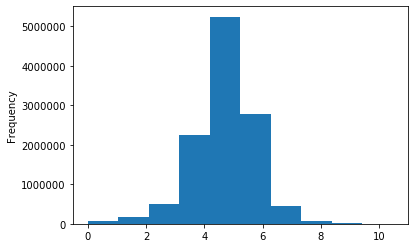

In [17]:
train_df[0].meter_reading.plot(kind='hist')

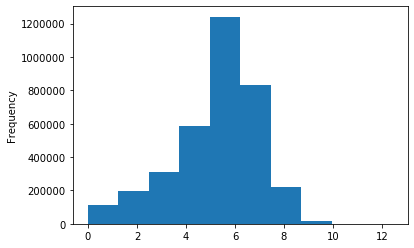

In [18]:
train_df[1].meter_reading.plot(kind='hist')

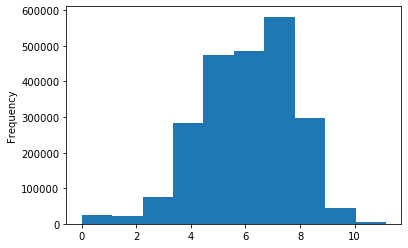

In [19]:
train_df[2].meter_reading.plot(kind='hist')

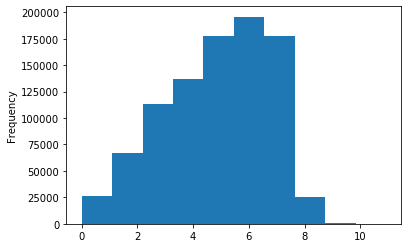

In [20]:
train_df[3].meter_reading.plot(kind='hist')

In [21]:
del m, df_train, df_test
gc.collect()

22

# Functions

In [22]:
def transform_data(df_train, df_test, name_re, name_me, name_ss):
    X_train = df_train.drop('meter_reading', axis=1)
    y_train = df_train[['meter_reading']]
    
    X_train, X_val, X_test, rare_dict = udf.rare_encoder(X_train, df_test, ['primary_use'], name=name_re)
    X_train, X_val, X_test, mean_dict = udf.mean_encoder(X_train, y_train, X_test, ['primary_use', 'country'], name=name_me)
    X_train_scaled, X_val, X_test_scaled = udf.scale_feats(X_train, X_test, name=name_ss)
    
    X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.20, random_state=42)
    
    print('Train: ', X_train_scaled.shape, y_train.shape)
    print('Validation: ', X_val_scaled.shape, y_val.shape)
    print('Test: ', X_test_scaled.shape)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val

In [23]:
def predict_lgb(X_train, y_train, X_val, y_val, X_test, params_dict, save_path):
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val)
    lgbm = lgb.train(params_dict, dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'val'], verbose_eval=False)
    joblib.dump(lgbm, save_path)
#     lgbm.save_model(save_path)
    
    pred = lgbm.predict(X_test)
    pred[pred < 0] = 0
    return pred

In [24]:
def predict_xgb(X_train, y_train, X_val, y_val, X_test, params_dict, save_path):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    xg = xgb.train(params_dict, dtrain, evals=[(dtrain, 'train'), (dval, 'val')], num_boost_round=1000, early_stopping_rounds=10, verbose_eval=False)
    joblib.dump(xg, save_path)
#     xg.save_model(save_path)
    
    pred = xg.predict(dtest)
    pred[pred < 0] = 0
    return pred

In [25]:
gc.collect()

66

# Electricity meter

### Transform data

In [ ]:
Xe_train_scaled, Xe_val_scaled, Xe_test_scaled, ye_train, ye_val = transform_data(train_df[0], test_df[0], 'rare_enc0.pkl', 'mean_enc0.pkl', 'scaler0.pkl')
Xe_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


### Lasso Regression

In [ ]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xe_train_scaled, ye_train)

val0 = lasso.predict(Xe_val_scaled)
print(lasso.score(Xe_val_scaled, ye_val))
print(np.sqrt(mean_squared_log_error(ye_val, val0)))

lasso0 = lasso.predict(Xe_test_scaled)
lasso0[lasso0 < 0] = 0
lasso0

### LightGBM

In [ ]:
study_lgb0 = joblib.load('../objects/electricity/study_lgb.pkl')
params_lgb0 = study_lgb0.best_trial.params
params_lgb0

In [ ]:
params_lgb0['num_iterations'] = 10000
params_lgb0['early_stopping_round'] = 10
params_lgb0['metric'] = 'rmse'
params_lgb0['num_threads'] = -1
params_lgb0['seed'] = 42
params_lgb0

In [ ]:
lgbm0 = predict_lgb(Xe_train_scaled, ye_train, Xe_val_scaled, ye_val, Xe_test_scaled, params_lgb0, '../objects/submission5/lgb0.pkl')
lgbm0

### XGBoost

In [ ]:
study_xgb0 = joblib.load('../objects/electricity/study_xgb.pkl')
params_xgb0 = study_xgb0.best_trial.params
params_xgb0['eval_metric'] = 'rmse'
params_xgb0['seed'] = 42
params_xgb0

In [ ]:
xg0 = predict_xgb(Xe_train_scaled, ye_train, Xe_val_scaled, ye_val, Xe_test_scaled, params_xgb0, '../objects/submission5/xgb0.pkl')
xg0

In [ ]:
del lasso, val0, study_lgb0
gc.collect()

# Chilled water meter

### Transform data

In [ ]:
Xc_train_scaled, Xc_val_scaled, Xc_test_scaled, yc_train, yc_val = transform_data(train_df[1], test_df[1], 'rare_enc1.pkl', 'mean_enc1.pkl', 'scaler1.pkl')
Xc_train_scaled.head()

### Lasso Regression

In [ ]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xc_train_scaled, yc_train)

val1 = lasso.predict(Xc_val_scaled)
print(lasso.score(Xc_val_scaled, yc_val))
print(np.sqrt(mean_squared_log_error(yc_val, val1)))

lasso1 = lasso.predict(Xc_test_scaled)
lasso1[lasso1 < 0] = 0
lasso1

### LightGBM

In [ ]:
study_lgb1 = joblib.load('../objects/chilledwater/study_lgb1.pkl')
params_lgb1 = study_lgb1.best_trial.params
params_lgb1

In [ ]:
params_lgb1['num_iterations'] = 10000
params_lgb1['early_stopping_round'] = 20
params_lgb1['metric'] = 'rmse'
params_lgb1['num_threads'] = -1
params_lgb1['seed'] = 42
params_lgb1

In [ ]:
lgbm1 = predict_lgb(Xc_train_scaled, yc_train, Xc_val_scaled, yc_val, Xc_test_scaled, params_lgb1, '../objects/submission5/lgb1.pkl')
lgbm1

### XGBoost

In [ ]:
study_xgb1 = joblib.load('../objects/chilledwater/study_xgb1.pkl')
params_xgb1 = study_xgb1.best_trial.params
params_xgb1['eval_metric'] = 'rmse'
params_xgb1['seed'] = 42
params_xgb1

In [ ]:
xg1 = predict_xgb(Xc_train_scaled, yc_train, Xc_val_scaled, yc_val, Xc_test_scaled, params_xgb1, '../objects/submission5/xgb1.pkl')
xg1

In [ ]:
del lasso, val1, study_lgb1
gc.collect()

# Steam meter

### Transform data

In [ ]:
Xs_train_scaled, Xs_val_scaled, Xs_test_scaled, ys_train, ys_val = transform_data(train_df[2], test_df[2], 'rare_enc2.pkl', 'mean_enc2.pkl', 'scaler2.pkl')
Xs_train_scaled.head()

### Lasso Regression

In [ ]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xs_train_scaled, ys_train)

val2 = lasso.predict(Xs_val_scaled)
print(lasso.score(Xs_val_scaled, ys_val))
print(np.sqrt(mean_squared_log_error(ys_val, val2)))

lasso2 = lasso.predict(Xs_test_scaled)
lasso2[lasso2 < 0] = 0
lasso2

### LightGBM

In [ ]:
study_lgb2 = joblib.load('../objects/steam/study_lgb2.pkl')
params_lgb2 = study_lgb2.best_trial.params
params_lgb2

In [ ]:
params_lgb2['num_iterations'] = 10000
params_lgb2['early_stopping_round'] = 20
params_lgb2['metric'] = 'rmse'
params_lgb2['num_threads'] = -1
params_lgb2['seed'] = 42
params_lgb2

In [ ]:
lgbm2 = predict_lgb(Xs_train_scaled, ys_train, Xs_val_scaled, ys_val, Xs_test_scaled, params_lgb2, '../objects/submission5/lgb2.pkl')
lgbm2

### XGBoost

In [ ]:
study_xgb2 = joblib.load('../objects/steam/study_xgb2.pkl')
params_xgb2 = study_xgb2.best_trial.params
params_xgb2['eval_metric'] = 'rmse'
params_xgb2['seed'] = 42
params_xgb2

In [ ]:
xg2 = predict_xgb(Xs_train_scaled, ys_train, Xs_val_scaled, ys_val, Xs_test_scaled, params_xgb2, '../objects/submission5/xgb2.pkl')
xg2

In [ ]:
del lasso, val2, study_lgb2
gc.collect()

# Hot water meter

### Transform data

In [ ]:
Xh_train_scaled, Xh_val_scaled, Xh_test_scaled, yh_train, yh_val = transform_data(train_df[3], test_df[3], 'rare_enc3.pkl', 'mean_enc3.pkl', 'scaler3.pkl')
Xh_train_scaled.head()

### Lasso Regression

In [ ]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xh_train_scaled, yh_train)

val3 = lasso.predict(Xh_val_scaled)
print(lasso.score(Xh_val_scaled, yh_val))
print(np.sqrt(mean_squared_log_error(yh_val, val3)))

lasso3 = lasso.predict(Xh_test_scaled)
lasso3[lasso3 < 0] = 0
lasso3

### LightGBM

In [ ]:
study_lgb3 = joblib.load('../objects/hotwater/study_lgb3.pkl')
params_lgb3 = study_lgb3.best_trial.params
params_lgb3

In [ ]:
params_lgb3['num_iterations'] = 10000
params_lgb3['early_stopping_round'] = 20
params_lgb3['metric'] = 'rmse'
params_lgb3['num_threads'] = -1
params_lgb3['seed'] = 42

In [ ]:
lgbm3 = predict_lgb(Xh_train_scaled, yh_train, Xh_val_scaled, yh_val, Xh_test_scaled, params_lgb3, '../objects/submission5/lgb3.pkl')
lgbm3

### XGBoost

In [ ]:
study_xgb3 = joblib.load('../objects/hotwater/study_xgb3.pkl')
params_xgb3 = study_xgb3.best_trial.params
params_xgb3['eval_metric'] = 'rmse'
params_xgb3['seed'] = 42
params_xgb3

In [ ]:
xg3 = predict_xgb(Xh_train_scaled, yh_train, Xh_val_scaled, yh_val, Xh_test_scaled, params_xgb3, '../objects/submission5/xgb3.pkl')
xg3

In [ ]:
del lasso, val3, study_lgb3
gc.collect()

# Combine predictions

In [ ]:
print('Test observations: ', [df.shape[0] for df in test_df])
print('Lasso predictions: ', list(map(len, [lasso0, lasso1, lasso2, lasso3])))
print('LightGBM predictions: ', list(map(len, [lgbm0, lgbm1, lgbm2, lgbm3])))
print('XGBoost predictions: ', list(map(len, [xg0, xg1, xg2, xg3])))

In [ ]:
# Electricity meter
pred0 = test_df[0][['square_feet']].copy()
pred0['lasso'] = np.expm1(lasso0)
pred0['lasso'] *= pred0.square_feet / pred0.square_feet.mean()
pred0['lgb'] = np.expm1(lgbm0)
pred0['lgb'] *= pred0.square_feet / pred0.square_feet.mean()
pred0['xgb'] = np.expm1(xg0)
pred0['xgb'] *= pred0.square_feet / pred0.square_feet.mean()
pred0

In [ ]:
# Chilled water meter
pred1 = test_df[1][['square_feet']].copy()
pred1['lasso'] = np.expm1(lasso1)
pred1['lasso'] *= pred1.square_feet / pred1.square_feet.mean()
pred1['lgb'] = np.expm1(lgbm1)
pred1['lgb'] *= pred1.square_feet / pred1.square_feet.mean()
pred1['xgb'] = np.expm1(xg1)
pred1['xgb'] *= pred1.square_feet / pred1.square_feet.mean()
pred1

In [ ]:
# Steam meter
pred2 = test_df[2][['square_feet']].copy()
pred2['lasso'] = np.expm1(lasso2)
pred2['lasso'] *= pred2.square_feet / pred2.square_feet.mean()
pred2['lgb'] = np.expm1(lgbm2)
pred2['lgb'] *= pred2.square_feet / pred2.square_feet.mean()
pred2['xgb'] = np.expm1(xg2)
pred2['xgb'] *= pred2.square_feet / pred2.square_feet.mean()
pred2

In [ ]:
# Hot water meter
pred3 = test_df[3][['square_feet']].copy()
pred3['lasso'] = np.expm1(lasso3)
pred3['lasso'] *= pred3.square_feet / pred3.square_feet.mean()
pred3['lgb'] = np.expm1(lgbm3)
pred3['lgb'] *= pred3.square_feet / pred3.square_feet.mean()
pred3['xgb'] = np.expm1(xg3)
pred3['xgb'] *= pred3.square_feet / pred3.square_feet.mean()
pred3

In [ ]:
# Log-transformed predictions
pred = pd.concat([pred0, pred1, pred2, pred3]).sort_index()
pred.reset_index(inplace=True)
pred.columns = ['row_id', 'square_feet', 'lasso', 'lgb', 'xgb']
pred

In [ ]:
del pred0, pred1, pred2, pred3
gc.collect()

# Convert units for site 0

In [ ]:
pred = pd.merge(mb[['row_id', 'site_id', 'meter']], pred, on='row_id', how='left')
pred

In [ ]:
# Site 0 meter 0 predictions in kWh
pred[(pred.site_id == 0) & (pred.meter == 0)].head()

In [ ]:
# Convert from kWh back to kBTU
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='lasso')
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='lgb')
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='xgb')
pred[(pred.site_id == 0) & (pred.meter == 0)].head()

In [ ]:
# Site 0 meter 1 predictions in tons
pred[(pred.site_id == 0) & (pred.meter == 1)].head()

In [ ]:
# Convert from kWh back to kBTU
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='lasso')
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='lgb')
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='xgb')
pred[(pred.site_id == 0) & (pred.meter == 1)].head()

In [ ]:
del mb
gc.collect()

# Save Predictions

In [ ]:
pred.describe()

In [ ]:
path = '../submissions/sub5/'
pred.to_pickle(f'{path}preds.pkl')
pd.read_pickle(f'{path}preds.pkl')

In [ ]:
submission

In [ ]:
# Lasso predictions
lasso_pred = submission.copy()
lasso_pred['meter_reading'] = pred['lasso']
lasso_pred

In [ ]:
# Lasso predictions
lgb_pred = submission.copy()
lgb_pred['meter_reading'] = pred['lgb']
lgb_pred

In [ ]:
# Lasso predictions
xgb_pred = submission.copy()
xgb_pred['meter_reading'] = pred['xgb']
xgb_pred

In [ ]:
lasso_pred.to_csv(f'{path}l1r.csv', index=False)
pd.read_csv(f'{path}l1r.csv')

In [ ]:
lgb_pred.to_csv(f'{path}lgb.csv', index=False)
pd.read_csv(f'{path}lgb.csv')

In [ ]:
xgb_pred.to_csv(f'{path}xgb.csv', index=False)
pd.read_csv(f'{path}xgb.csv')

### Test RMSLE:
##### Lasso regression:  (Public),  (Private)
##### LightGBM:  (Public),  (Private)
##### XGBoost:  (Public),  (Private)

# Combine LightGBM and XGBoost predictions

In [ ]:
xl = pd.merge(lgb_pred, xgb_pred, on='row_id', how='left')
xl.columns = ['row_id', 'lgb', 'xgb']
xl.head()

In [ ]:
xl['xl91'] = (xl.lgb * 0.9) + (xl.xgb * 0.1)
xl['xl73'] = (xl.lgb * 0.7) + (xl.xgb * 0.3)
xl['xl55'] = xl[['lgb', 'xgb']].mean(axis=1)
xl['xl37'] = (xl.lgb * 0.3) + (xl.xgb * 0.7)
xl['xl19'] = (xl.lgb * 0.1) + (xl.xgb * 0.9)
xl.head()

In [ ]:
xl1 = xl[['row_id', 'xl91']]
xl1.columns = ['row_id', 'meter_reading']

xl1.to_csv(f'{path}xl1.csv', index=False)
pd.read_csv(f'{path}xl1.csv')

In [ ]:
xl2 = xl[['row_id', 'xl73']]
xl2.columns = ['row_id', 'meter_reading']

xl2.to_csv(f'{path}xl2.csv', index=False)
pd.read_csv(f'{path}xl2.csv')

In [ ]:
xl3 = xl[['row_id', 'xl55']]
xl3.columns = ['row_id', 'meter_reading']

xl3.to_csv(f'{path}xl3.csv', index=False)
pd.read_csv(f'{path}xl3.csv')

In [ ]:
xl4 = xl[['row_id', 'xl37']]
xl4.columns = ['row_id', 'meter_reading']

xl4.to_csv(f'{path}xl4.csv', index=False)
pd.read_csv(f'{path}xl4.csv')

In [ ]:
xl5 = xl[['row_id', 'xl19']]
xl5.columns = ['row_id', 'meter_reading']

xl5.to_csv(f'{path}xl5.csv', index=False)
pd.read_csv(f'{path}xl5.csv')